## 00. Import libraries and load data

Note: This Jupyter Notebook was created as part of the group work. Each member has contributed similarly to the result.

In [39]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 1. Read in the data

In [40]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed_unscaled.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [41]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y = df["Promotion"]
X = df.loc[:, ~df.columns.isin(['Promotion', 'Product_UID'])]

In [42]:
# We check if y equals the attribute we want to predict (Promotion)
y

0       0
1       1
2       1
3       0
4       0
       ..
1717    0
1718    1
1719    0
1720    0
1721    1
Name: Promotion, Length: 1722, dtype: int64

In [43]:
# We check if X equals all other attributes than Promotion to predict this attribute 
X

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Demand,Weekday
0,1,1,195,72.72,5,1,115,2
1,0,1,117,80.16,15,1,229,2
2,0,1,247,62.94,10,1,157,2
3,1,1,139,87.63,10,1,52,2
4,3,1,152,54.41,0,1,59,2
...,...,...,...,...,...,...,...,...
1717,3,1,129,62.83,10,0,143,5
1718,2,1,104,98.97,10,0,54,5
1719,2,1,494,111.25,10,0,70,5
1720,3,2,625,69.62,5,1,69,5


# 2. Split the data with Split Validation

In [44]:
# We check the imbalance of the data set to get further information for potential data augmentation techniques
y.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [45]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape
print("Before:", Counter(y_train))

Before: Counter({0: 743, 1: 410})


# 3. Split the data with Cross Validation

In [46]:
# We use stratified cross validation to get a robust model with the same class balances in each fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## 3.1 Gini - No SMOTE

In [47]:
# We use the best parameters that we have derived before
best_params_gini = {'max_depth': 4, 'min_samples_split':2, 'min_samples_leaf': 2}

In [48]:
# We start with building trees based on the cross validation
# We see that we have a robust model because our accuracy score is independant of the data combinations
# Our average accuracy is the mean of the different scores
score = cross_val_score(tree.DecisionTreeClassifier(criterion='gini', splitter='best', **best_params_gini, random_state=42), X, y, cv=kf, scoring="accuracy")
print(score)
average_accuracy = score.mean()
average_accuracy

[0.93641618 0.90751445 0.87790698 0.89534884 0.87790698 0.88372093
 0.90116279 0.9244186  0.90697674 0.90116279]


np.float64(0.901253528700094)

In [49]:
# We now want to find the best parameters based on the cross validation
# We start with a tree with no specified parameters
dt_noparam = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
dt_noparam.fit(X_train, y_train)
y_pred = dt_noparam.predict(X_test)
accuracy_score(y_test, y_pred)

0.8980667838312829

[Text(0.6687929010115607, 0.9782608695652174, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = 0'),
 Text(0.6572322073699421, 0.9347826086956522, 'Discount <= 7.5\ngini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = 0'),
 Text(0.6630125541907514, 0.9565217391304348, 'True  '),
 Text(0.6456715137283237, 0.8913043478260869, 'gini = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = 0'),
 Text(0.6687929010115607, 0.8913043478260869, 'Demand <= 145.5\ngini = 0.413\nsamples = 377\nvalue = [267, 110]\nclass = 0'),
 Text(0.45030256502890176, 0.8478260869565217, 'Price <= 159.95\ngini = 0.353\nsamples = 306\nvalue = [236, 70]\nclass = 0'),
 Text(0.2257496387283237, 0.8043478260869565, 'Inventory Level <= 100.5\ngini = 0.339\nsamples = 300\nvalue = [235, 65]\nclass = 0'),
 Text(0.057803468208092484, 0.7608695652173914, 'Weekday <= 1.5\ngini = 0.133\nsamples = 42\nvalue = [39, 3]\nclass = 0'),
 Text(0.046242774566473986, 0.717391304347826, 'Price <= 141.96\ngi

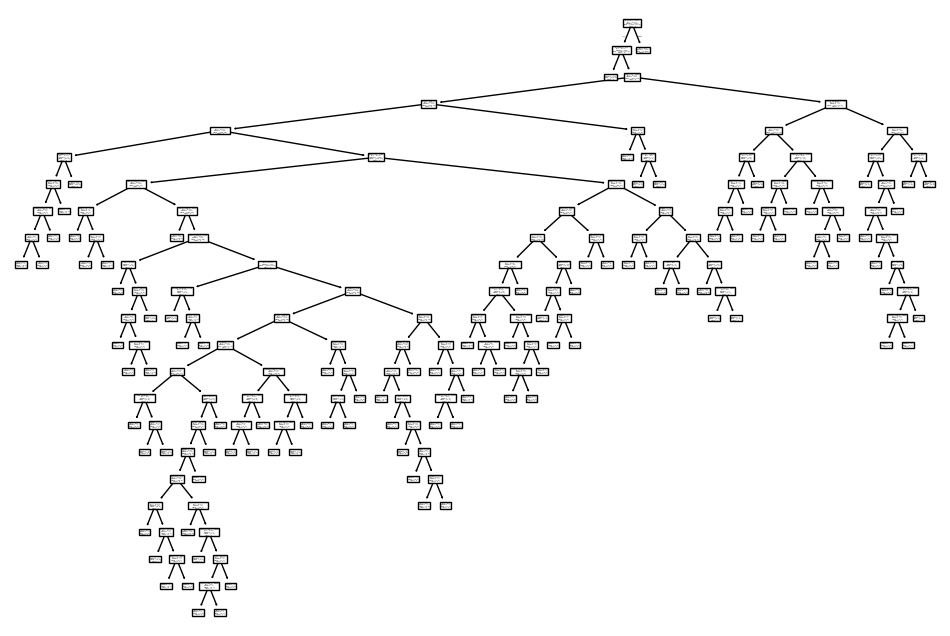

In [50]:
# We plot the tree with no specified paramters to look at the unpruned tree
feature_names = X_train.columns
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_noparam.fit(X_train, y_train), feature_names=feature_names, class_names=['0', '1'])

In [51]:
# We set a range of Parameters that GridSearchCV will try out for us in every possible combination
params = {'max_depth': [1, 2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [2, 3, 4, 5]}
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)

# Note that we tried out different scoring paramters like accuracy, f1, recall. Because we want to keep the interpretability with a max. depth of 4, it would lead to the same results
gcv = GridSearchCV(estimator=clf, param_grid=params, return_train_score=True, cv=10)
gcv.fit(X_train, y_train)
print(gcv.best_params_)

# We also used RandomizedSearchCV to compare the best paramaters with another method. We noticed that the results are always different, so we decided to stick 
# with the GridSearchCV, as best parameters are always constant. We know that there is an option to always get the same result (random_state), but as our paramter
# space is rather small, GridSearchCV works perfectly fine
rcv = RandomizedSearchCV(estimator=clf, param_distributions=params, return_train_score=True, cv=10)
rcv.fit(X_train, y_train)
print(rcv.best_params_)

{'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
{'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 2}


In [52]:
# These are the best possible estimators on which the model should be trained on 
print(gcv.best_estimator_)
model = gcv.best_estimator_
model.fit(X_train, y_train)
y_pred_pruned = model.predict(X_test)
gcv_accuracy = accuracy_score(y_test, y_pred_pruned)
print(gcv_accuracy)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, random_state=42)
0.8945518453427065


In [53]:
# We want to check wether our model is robust or if it is dependant on the data. The only way to check this for cross validation, is to 
# evaluate the accuracy based on the train data and compare the results with the accuracy of the test data. If they
# deviate less than 5%, the model is independant of the underlying data and thus is robust
# Predict on both training and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Define a tolerance of ±5% of the test accuracy
tolerance = 0.05 * test_accuracy

# Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Robustness check
if abs(train_accuracy - test_accuracy) < tolerance:
    print("Passed the Robustness Check!")
else:
    print("Didn't pass the Robustness Check!")


Training Accuracy: 0.9046
Test Accuracy: 0.8946
Passed the Robustness Check!


[Text(0.5, 0.75, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.25, 0.25, 'gini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 300\nvalue = [0, 300]\nclass = Promotion'),
 Text(0.625, 0.5, '  False')]

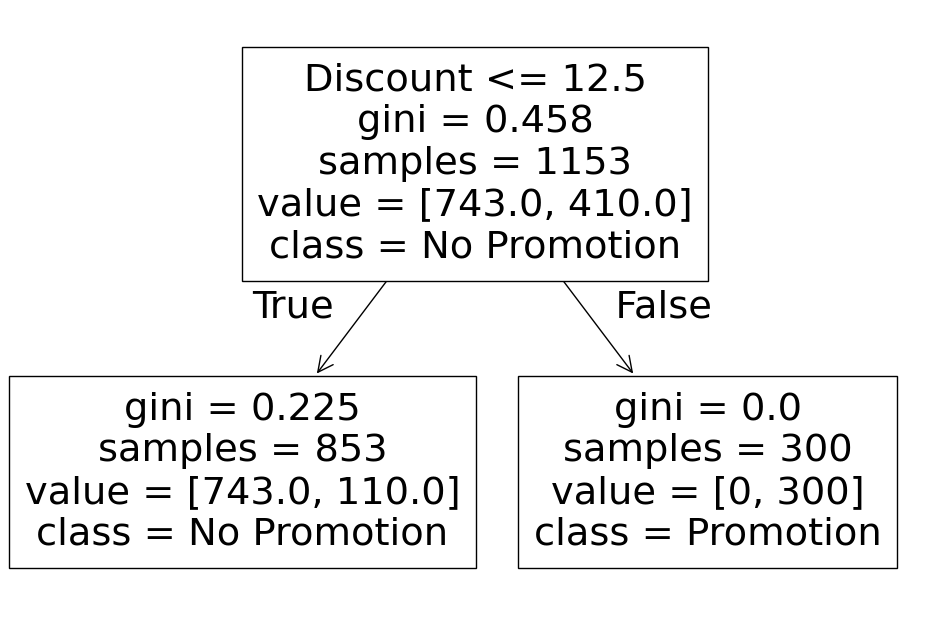

In [54]:
# We plot the pruned tree
feature_names = X_train.columns
plt.figure(figsize=(12, 8))
tree.plot_tree(model, feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [55]:
# We can also get our rules in textual format
feature_names = X_train.columns
text_representation = tree.export_text(model, feature_names=feature_names)
print(text_representation)

|--- Discount <= 12.50
|   |--- class: 0
|--- Discount >  12.50
|   |--- class: 1



Text(0.5, 1.0, 'Confusion Matrix')

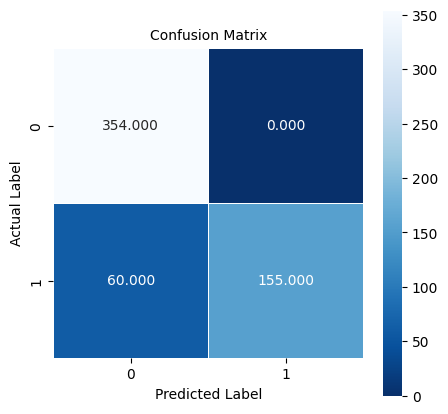

In [56]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_pruned)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [57]:
# We analyze the classification report to get further insights in the performance of our model
print(classification_report(y_test, y_pred_pruned))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       354
           1       1.00      0.72      0.84       215

    accuracy                           0.89       569
   macro avg       0.93      0.86      0.88       569
weighted avg       0.91      0.89      0.89       569

